## Final Project
### Effect of Stellar Mass on Planetary Multiplicity

CS-GY 6053 – Foundations of Data Science
<br><br> Claire Hattaway, Chiranjeev Kumar, Hyun Sang Ryu, Raunak Ahmed
***

**Question/Estimand**
<ul>How does stellar mass influence the number of planets that a star hosts in its solar system (planetary multiplicity)?</ul>

**Data Description**
<ul>Data Source: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=STELLARHOSTS</ul>
<ul>Description: The dataset is hosted by NASA’s Exoplanet Archive with rows representing stars that are solar hosts in a solar system. Within the dataset, there are columns present that cover the necessary information needed to account for our treatment, outcome and confound variables. Column name descriptions and a sample of the data is provided below.
<ul><li>sy_name: Name of solar system</li>
<li>hostname: Name of host star in the system</li>
<li>sy_pnum: Number of planets in the system</li>
<li>st_teff: Stellar effective temperature (Kelvin)</li>
<li>st_mass: Stellar mass</li>
<li>st_met: Stellar metallicity</li></ul></ul>

In [1]:
import pandas as pd

df = pd.read_csv('data.csv')
print(df.head())

  sy_name   hostname  sy_pnum Stellar Parameter Reference  st_teff  st_mass  \
0  14 Her     14 Her        2                       TICv8   5280.0     0.91   
1  16 Cyg  HIP 96895        1                       TICv8   5778.0     1.04   
2  16 Cyg   16 Cyg B        1                       TICv8   5747.0     1.03   
3  47 UMa     47 UMa        3                       TICv8   5872.0     1.06   
4  51 Peg     51 Peg        1                       TICv8   5758.0     1.03   

   st_met st_metratio  
0    0.40       [M/H]  
1    0.09       [M/H]  
2    0.06       [M/H]  
3    0.04       [M/H]  
4    0.18       [M/H]  


**Causal Model**
<br>Variables:
<ul><li>Treatment (T): Stellar mass- calculated mass of a star</li>
<li>Outcome (Y): Number of planets- the number of planets hosted by a solar system</li>
<li>Confound 1 (E): Stellar effective temperature- measure of star’s surface temperature, using luminosity and radius</li>
<li>Confound 2 (M): Stellar metallicity- abundance of elements in a star that is heavier than helium and hydrogen</li></ul>

![DAG](DAG.png)

**How do the variables interact with one another?**
<ul><li>Stellar metallicity: Higher metallicity ratios lead stars to have cooler temperatures and lose more mass over time than stars with lower metallicity. Additionally, higher metallicty ratios increase the amount of solid material available for planet formation, tending to yield a greater number of planets in a system.</li>
<li>Stellar mass: An increase in stellar mass increases the star's effective temperature, due to the increased gravitational pressure. Planetary multiplicity also decreases with increased stellar mass.</li>
<li> Stellar effective temperature: Similar to stellar mass, increasing stellar effect temperatures tends to decrease the number of planets in the system.</li></ul>

References:
https://burro.case.edu/Academics/Astr222/Galaxy/Structure/metals.html#:~:text=Line%20blanketing:%20lots%20of%20metals,them%20cooler%20(redder)%20temperatures.
<br>https://public.nrao.edu/ask/does-metallicity-affect-the-evolution-of-a-star/#:~:text=The%20abundance%20of%20elements%20heavier,supernova%20and%20a%20black%20hole.
<br>https://iopscience.iop.org/article/10.3847/1538-4357/ab0205/pdf#:~:text=The%20whole%20sample%20is%20unevenly,planets%20to%20compute%20the%20tracers.&text=metallicities%2C%20but%20these%20systems%20were,tonically%20increasing%20with%20stellar%20metallicity.&text=reflects%20the%20final%20outcome%20of,directly%20the%20planet%20formation%20efficiency.
<br>https://iopscience.iop.org/article/10.3847/1538-3881/ab7373/pdf#:~:text=The%20Kepler%20mission%20has%20discovered,%CE%94AIC%EF%82%A0%E2%88%BC%EF%82%A05




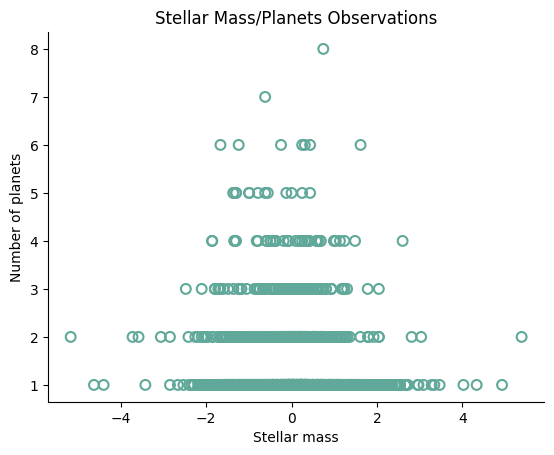

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def standardize(series):
    return (series - series.mean()) / series.std()

mass_std = standardize(df.st_mass)
met_std = standardize(df.st_met)
teff_std = standardize(df.st_teff)

# Initial plot of data
sns.scatterplot(x=mass_std, y=df.sy_pnum, edgecolor='#60a899', facecolor='none', s=50, linewidth=1.5)
plt.xlabel("Stellar mass")
plt.ylabel("Number of planets")
plt.title('Stellar Mass/Planets Observations')
sns.despine()

**Statistical Model**
<br>Assumed Distribution for Outcome Variable
<br>$Y_i \sim Poisson(\lambda_i)$
<br> Given that planetary multiplicity is a countable feature, we have chosen a Poisson distribution to capture the low probability of a very high number of planets in a system.

Model Structures
<br>No collider: $log(\lambda_i) = \alpha + \beta T_i + \beta M_i$
<br>Collider: $log(\lambda_i) = \alpha + \beta T_i + \beta M_i + \beta E_i$
<br>For our project, we will be using two models to estimate the number of planets in a given system. Since stellar effect temperature is a collider in our causal model, we will examine two models: one excluding temperature as a predictor and one including temperature.

Priors
<br>$\alpha \sim Normal(0.4, 0.6)$
<br>$\beta \sim Normal(0, 0.1)$
<br>Prior values were chosen using a combination of outside sources and prior predictive simulations. Based on resources, we were able to estimate that the average number of planets for a given solar system is between 1 and 2. Given this estimation, we chose to use 1.5 as our intercept prior, using the log transformation for the Poisson link function to yield our intercept mean of 0.4. Additionally, we will be using standardized confounds, so our slope prior is set at a mean value of 0. The standard deviations for $\alpha$ and $\beta$ values were adjusted after performing the prior predictive simulation. Prior simulations are included below for reference.
<br>Resource: https://www.sciencefocus.com/space/on-average-how-many-planets-are-in-orbit-around-each-star

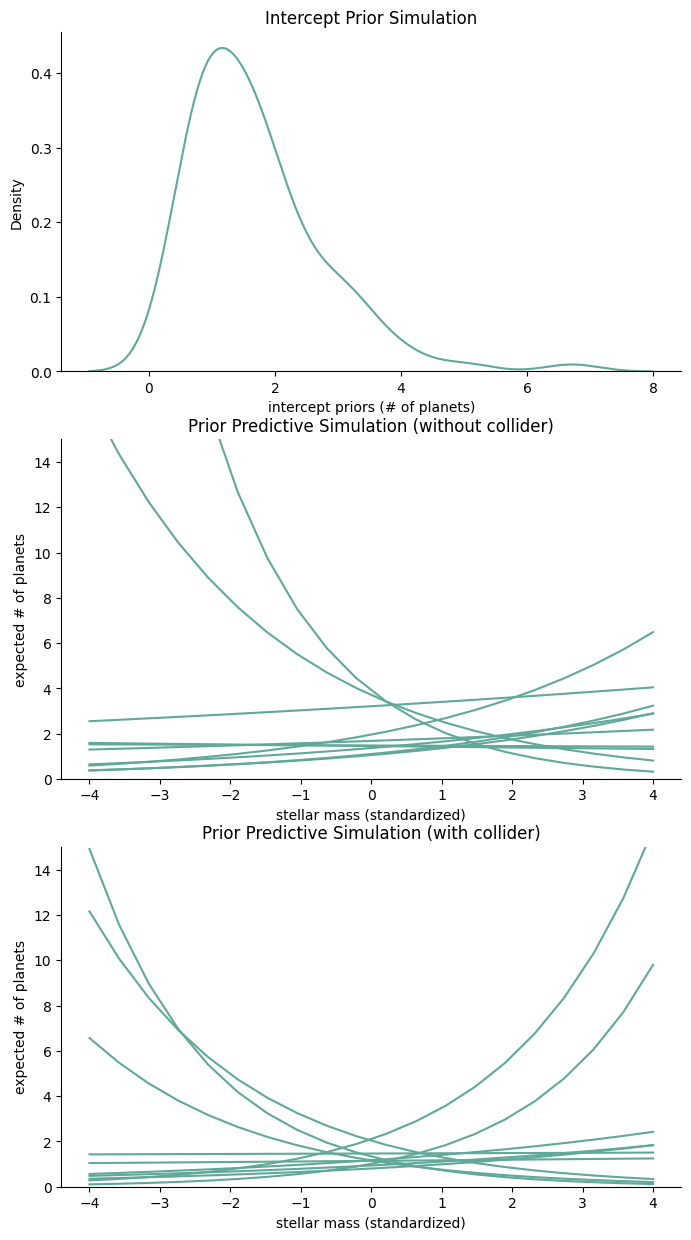

In [3]:
import pymc as py
from scipy import stats
import numpy as np

_, ax = plt.subplots(3, 1, figsize=(8,15))

# Intercept predictive simulation
alpha_io = stats.norm.rvs(0.4, 0.6, size = 100)
lambda_io = np.exp(alpha_io)

sns.kdeplot(lambda_io, color="#60a899", ax=ax[0])
ax[0].set_xlabel("intercept priors (# of planets)")
ax[0].set_ylim(bottom=-2e-13)
ax[0].set_title("Intercept Prior Simulation")

# Prior predictive simulation without collider
NUM_LINES = 10
t_seq = np.linspace(-4, 4, 20)
m_seq = np.linspace(-5, 2, 20)

alpha = stats.norm.rvs(0.4, 0.6, size=NUM_LINES)
beta = stats.norm.rvs(0, 0.2, size=NUM_LINES)

for i in range(NUM_LINES):
    lambdas = np.exp(alpha[i] + beta[i] * t_seq + beta[i] * m_seq)
    ax[1].plot(t_seq, lambdas, color="#60a899")
    
ax[1].set_ylim((0,15))
ax[1].set_ylabel("expected # of planets")
ax[1].set_xlabel("stellar mass (standardized)")
ax[1].set_title("Prior Predictive Simulation (without collider)")

# Collider as a predictor prior predictive simulation
NUM_LINES = 10
t_seq = np.linspace(-4, 4, 20)
m_seq = np.linspace(-5, 2, 20)
e_seq = np.linspace(-4, 4, 20)

alpha = stats.norm.rvs(0.4, 0.6, size=NUM_LINES)
beta = stats.norm.rvs(0, 0.1, size=NUM_LINES)

for i in range(NUM_LINES):
    lambdas = np.exp(alpha[i] + beta[i] * t_seq + beta[i] * m_seq + beta[i] * e_seq)
    ax[2].plot(t_seq, lambdas, color="#60a899")
    
ax[2].set_ylim((0,15))
ax[2].set_ylabel("expected # of planets")
ax[2].set_xlabel("stellar mass (standardized)")
ax[2].set_title("Prior Predictive Simulation (with collider)")
sns.despine();

In [4]:
# Core libraries
# !pip install numpy pandas matplotlib pymc arviz

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bayesian modeling
import pymc as pm
import arviz as az

# For reproducibility
rng = np.random.default_rng(42)

# ----- 2.1 True parameters for simulation -----
N_sim = 1000

alpha_true = -0.2      # intercept
beta_T_true = 0.6      # effect of treatment (mass)
beta_Z_true = 0.4      # effect of confound (metallicity)
mu_T_true = 1.0        # mean of treatment
sigma_T_true = 0.3     # sd of treatment
mu_Z_true = 0.0        # mean of confound
sigma_Z_true = 0.5     # sd of confound
gamma_ZT_true = 0.5    # how Z influences T (to create confounding)

# ----- 2.2 Simulate confound (Z), treatment (T), and outcome (Y) -----
Z_sim = rng.normal(mu_Z_true, sigma_Z_true, size=N_sim)
T_sim = rng.normal(mu_T_true + gamma_ZT_true * Z_sim, sigma_T_true, size=N_sim)

eta_sim = alpha_true + beta_T_true * T_sim + beta_Z_true * Z_sim
lambda_sim = np.exp(eta_sim)
Y_sim = rng.poisson(lam=lambda_sim)

sim_data = pd.DataFrame({
    "T": T_sim,
    "Z": Z_sim,
    "Y": Y_sim
})

sim_data.head()

,T,Z,Y
0,1.058394,0.152359,0
1,0.521218,-0.519992,1
2,1.063271,0.375226,0
3,1.425314,0.470282,2
4,0.513139,-0.975518,0


In [5]:
# ----- Fit the same model in PyMC on simulated data -----
with pm.Model() as sim_model:
    # Priors
    alpha = pm.Normal("alpha", mu=0.0, sigma=1.0)
    beta_T = pm.Normal("beta_T", mu=0.0, sigma=1.0)
    beta_Z = pm.Normal("beta_Z", mu=0.0, sigma=1.0)
    
    # Linear predictor
    eta = alpha + beta_T * sim_data["T"].values + beta_Z * sim_data["Z"].values
    mu = pm.math.exp(eta)
    
    # Likelihood (Poisson outcome)
    Y_obs = pm.Poisson("Y_obs", mu=mu, observed=sim_data["Y"].values)
    
    # Sampling
    sim_trace = pm.sample(
        draws=2000,
        tune=1000,
        target_accept=0.9,
        random_seed=42,
        cores=2
    )

az.summary(sim_trace, var_names=["alpha", "beta_T", "beta_Z"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_T, beta_Z]


/Users/chiranjeevkundu/Desktop/exoplanet-project/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.331,0.092,-0.506,-0.153,0.003,0.002,902.0,1030.0,1.0
beta_T,0.685,0.085,0.530,0.859,0.003,0.002,906.0,1020.0,1.0
beta_Z,0.361,0.070,0.242,0.504,0.002,0.002,1140.0,1009.0,1.0


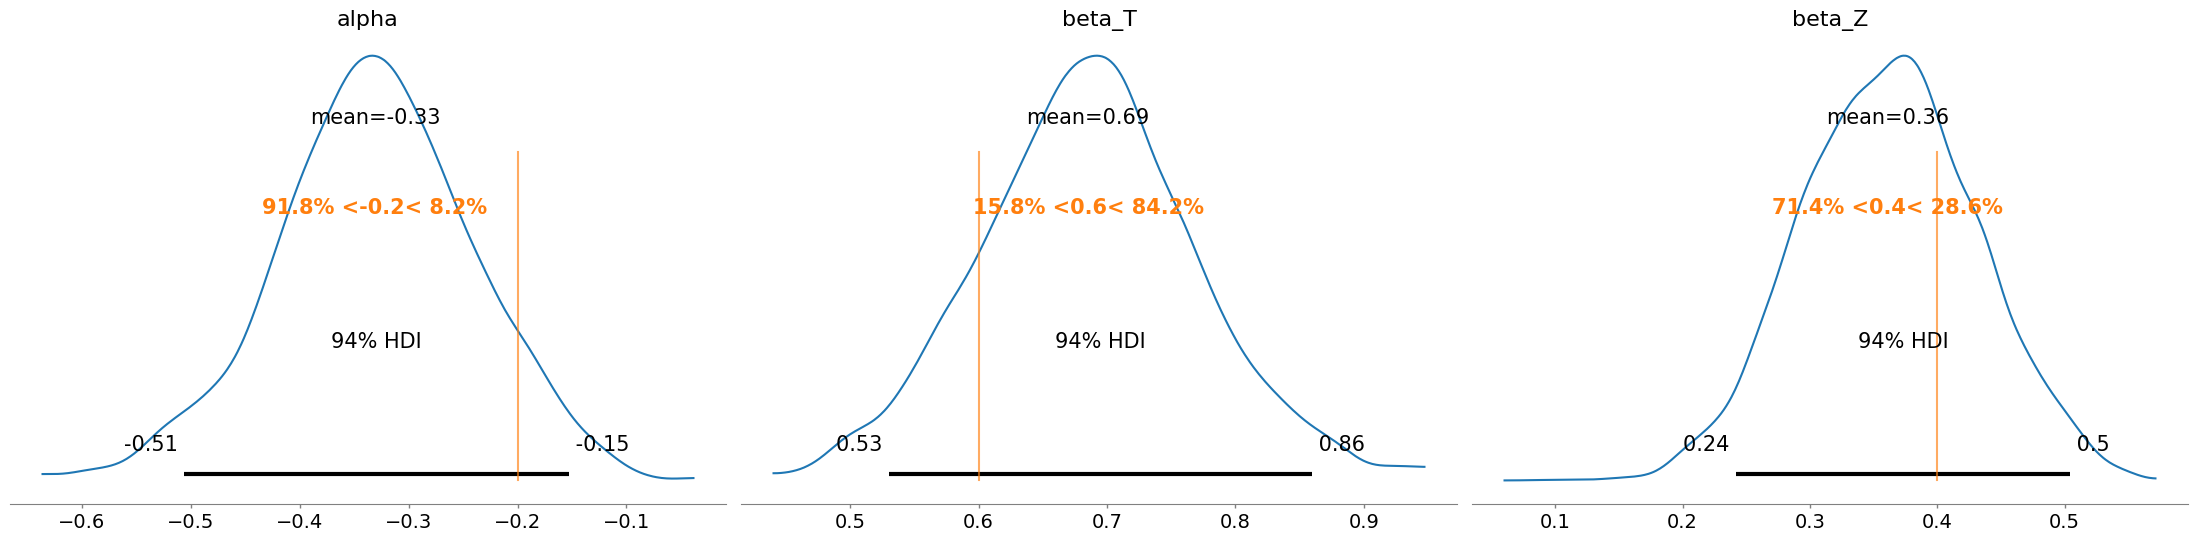

In [6]:
# ----- Posterior vs true values -----
true_values = {
    "alpha": [{"ref_val": alpha_true}],
    "beta_T": [{"ref_val": beta_T_true}],
    "beta_Z": [{"ref_val": beta_Z_true}]
}

az.plot_posterior(
    sim_trace,
    var_names=["alpha", "beta_T", "beta_Z"],
    ref_val=true_values
)
plt.tight_layout()
plt.show()

In [7]:
df = pd.read_csv("data.csv")

df.head()
df.describe()

,sy_pnum,st_teff,st_mass,st_met
count,1617.000000,1615.000000,1617.000000,1617.000000
mean,1.443414,5594.919610,0.999742,0.026117
std,0.854180,537.510118,0.161499,0.212347
min,1.000000,3259.000000,0.164568,-1.050000
25%,1.000000,5310.405000,0.910000,-0.099800
50%,1.000000,5662.200000,1.008000,0.051500
75%,2.000000,5946.910000,1.090000,0.173300
max,8.000000,7852.930000,1.870000,0.470000


In [8]:
# ----- Select variables and basic cleaning -----
# Y: number of planets
# T: stellar mass
# Z: stellar metallicity

df_model = df[["sy_pnum", "st_mass", "st_met"]].copy()

# Drop rows with missing values in any of the three variables
df_model = df_model.dropna(subset=["sy_pnum", "st_mass", "st_met"])

# Ensure outcome is integer and positive
df_model = df_model[df_model["sy_pnum"] > 0]
df_model["sy_pnum"] = df_model["sy_pnum"].astype(int)

df_model.shape, df_model.head(10)

((1617, 3),
    sy_pnum  st_mass  st_met
 0        2     0.91    0.40
 1        1     1.04    0.09
 2        1     1.03    0.06
 3        3     1.06    0.04
 4        1     1.03    0.18
 5        7     0.90    0.35
 6        3     0.98   -0.03
 7        1     0.96   -0.07
 8        1     1.29    0.29
 9        1     0.79    0.17)

In [9]:
T_raw = df_model["st_mass"].values
Z_raw = df_model["st_met"].values
Y = df_model["sy_pnum"].values

T_mean, T_std = T_raw.mean(), T_raw.std()
Z_mean, Z_std = Z_raw.mean(), Z_raw.std()

T_stdzd = (T_raw - T_mean) / T_std
Z_stdzd = (Z_raw - Z_mean) / Z_std

df_model["T_std"] = T_stdzd
df_model["Z_std"] = Z_stdzd

df_model[["sy_pnum", "T_std", "Z_std"]].head()

,sy_pnum,T_std,Z_std
0,2,-0.555853,1.761263
1,1,0.249354,0.300938
2,1,0.187415,0.159616
3,3,0.373232,0.065401
4,1,0.187415,0.724903


In [10]:
with pm.Model() as real_model:
    # Priors
    alpha = pm.Normal("alpha", mu=0.0, sigma=1.0)
    beta_T = pm.Normal("beta_T", mu=0.0, sigma=1.0)  # causal effect of mass
    beta_Z = pm.Normal("beta_Z", mu=0.0, sigma=1.0)  # confound effect (metallicity)
    
    # Linear predictor
    eta = alpha + beta_T * df_model["T_std"].values + beta_Z * df_model["Z_std"].values
    mu = pm.math.exp(eta)
    
    # Outcome likelihood
    Y_obs = pm.Poisson("Y_obs", mu=mu, observed=df_model["sy_pnum"].values)
    
    # Sample from posterior
    real_trace = pm.sample(
        draws=3000,
        tune=1500,
        target_accept=0.9,
        random_seed=123,
        cores=2
    )

az.summary(real_trace, var_names=["alpha", "beta_T", "beta_Z"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_T, beta_Z]


/Users/chiranjeevkundu/Desktop/exoplanet-project/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_500 tune and 3_000 draw iterations (3_000 + 6_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.366,0.021,0.325,0.402,0.0,0.0,6601.0,4369.0,1.0
beta_T,-0.044,0.020,-0.084,-0.007,0.0,0.0,5235.0,4653.0,1.0
beta_Z,0.002,0.021,-0.037,0.040,0.0,0.0,6267.0,4591.0,1.0


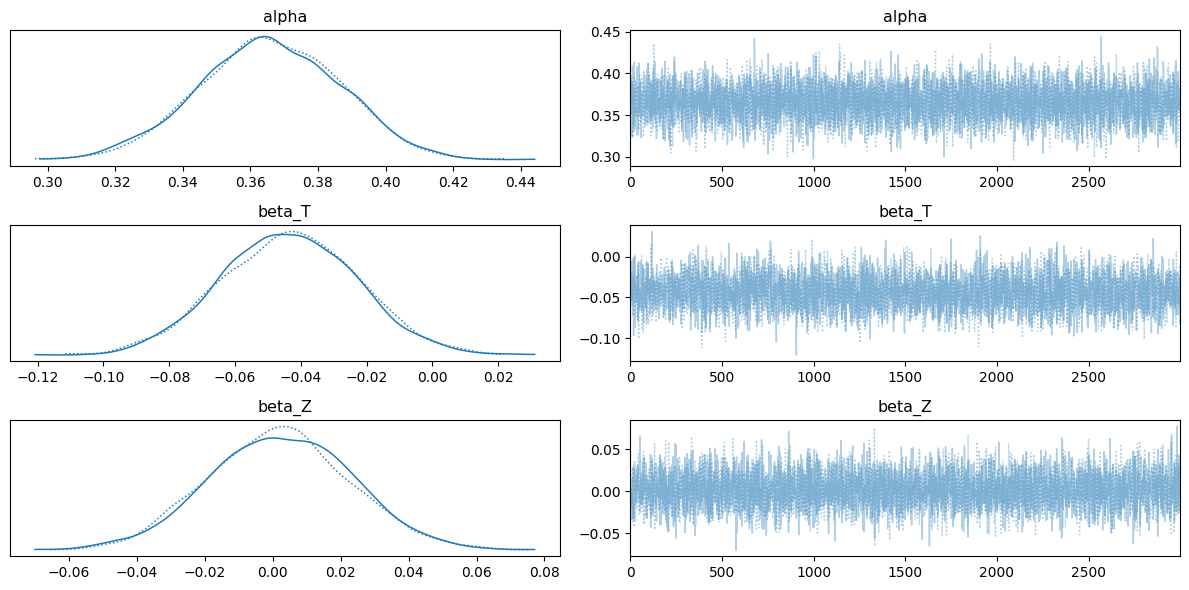

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.366,0.021,0.325,0.402,0.0,0.0,6601.0,4369.0,1.0
beta_T,-0.044,0.020,-0.084,-0.007,0.0,0.0,5235.0,4653.0,1.0
beta_Z,0.002,0.021,-0.037,0.040,0.0,0.0,6267.0,4591.0,1.0


In [11]:
az.plot_trace(real_trace, var_names=["alpha", "beta_T", "beta_Z"])
plt.tight_layout()
plt.show()

summary = az.summary(real_trace, var_names=["alpha", "beta_T", "beta_Z"])
summary

In [ ]:
{
 "nbformat": 4,
 "nbformat_minor": 5,
 "metadata": {
  "kernelspec": {
   "display_name": "Python 3",
   "language": "python",
   "name": "python3"
  },
  "language_info": {
   "name": "python",
   "version": "3.10"
  }
 },
 "cells": [
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# Foundations of Data Science Final Project\n",
    "## Exoplanets, Stellar Properties, and Causal Inference\n",
    "\n",
    "**Course:** NYU Tandon – Foundations of Data Science  \n",
    "**Instructor:** Dr. Darryl Reeves  \n",
    "**Student:** _Your Name_\n",
    "\n",
    "---\n",
    "\n",
    "### 1. Introduction\n",
    "\n",
    "The goal of this project is to investigate how properties of stars affect the **number of planets** they host.  \n",
    "We focus on three stellar characteristics:\n",
    "\n",
    "- $T$: Stellar mass (in solar masses)\n",
    "- $E$: Effective temperature (Kelvin)\n",
    "- $M$: Metallicity (roughly, heavy-element abundance)\n",
    "- $Y$: Number of confirmed planets orbiting the star\n",
    "\n",
    "Using the tools from the course (Bayesian inference, GLMs, DAGs, posterior predictive checks, causal estimands, and model comparison), we build a **Poisson regression model** with a **log link** for the planet counts and interpret the causal effect of metallicity and mass on $Y$.\n",
    "\n",
    "The data come from an exoplanet catalog (subset), stored in `data.csv`."
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "### 2. DAG and Causal Story\n",
    "\n",
    "The given DAG (in the project handout) encodes the following structure:\n",
    "\n",
    "- $T$ (stellar mass) $\\rightarrow E$ (effective temperature)\n",
    "- $M$ (metallicity) $\\rightarrow E$\n",
    "- $T, E, M \\rightarrow Y$ (number of planets)\n",
    "\n",
    "So temperature is partly determined by mass and metallicity, and all three can influence the number of planets.  \n",
    "We are mainly interested in the **causal effect of metallicity and mass on the number of planets**:\n",
    "\n",
    "$$\n",
    "\\text{E}[Y \\mid \\operatorname{do}(M=m_{\\text{hi}})] - \\text{E}[Y \\mid \\operatorname{do}(M=m_{\\text{lo}})]\n",
    "$$\n",
    "\n",
    "Because $Y$ is a count without a fixed maximum, we use a **Poisson GLM with log link**, as introduced in the lectures."
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## 3. Setup and Data Cleaning"
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "execution_count": null,
   "outputs": [],
   "source": [
    "import numpy as np\n",
    "import pandas as pd\n",
    "import pymc as pm\n",
    "import arviz as az\n",
    "import matplotlib.pyplot as plt\n",
    "\n",
    "az.style.use(\"arviz-darkgrid\")\n",
    "%config InlineBackend.figure_format = \"retina\""
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "execution_count": null,
   "outputs": [],
   "source": [
    "# Load dataset (assumes data.csv is in the same directory)\n",
    "df = pd.read_csv(\"data.csv\")\n",
    "\n",
    "# Keep the relevant columns and drop missing values\n",
    "df = df[[\"sy_pnum\", \"st_mass\", \"st_teff\", \"st_met\"]].dropna()\n",
    "\n",
    "# Rename columns to match notation in the project\n",
    "df = df.rename(columns={\n",
    "    \"sy_pnum\": \"Y\",   # number of planets\n",
    "    \"st_mass\": \"T\",   # mass\n",
    "    \"st_teff\": \"E\",   # effective temperature\n",
    "    \"st_met\": \"M\"     # metallicity\n",
    "})\n",
    "\n",
    "df.head()"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "### 3.1 Summary Statistics and Exploration"
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "execution_count": null,
   "outputs": [],
   "source": [
    "df.describe()"
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "execution_count": null,
   "outputs": [],
   "source": [
    "fig, axes = plt.subplots(1, 3, figsize=(14, 4))\n",
    "axes[0].scatter(df[\"T\"], df[\"Y\"], alpha=0.5)\n",
    "axes[0].set_xlabel(\"Mass (T)\")\n",
    "axes[0].set_ylabel(\"Number of planets (Y)\")\n",
    "\n",
    "axes[1].scatter(df[\"M\"], df[\"Y\"], alpha=0.5)\n",
    "axes[1].set_xlabel(\"Metallicity (M)\")\n",
    "\n",
    "axes[2].scatter(df[\"E\"], df[\"Y\"], alpha=0.5)\n",
    "axes[2].set_xlabel(\"Temperature (E)\")\n",
    "\n",
    "plt.tight_layout()\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "**Interpretation:**  \n",
    "- $Y$ is a small count (0, 1, 2, …), right-skewed.\n",
    "- Metallicity $M$ appears positively related to the number of planets.\n",
    "- Mass $T$ and temperature $E$ also show some patterns.\n",
    "\n",
    "This motivates a **Poisson GLM with log link**, as used in the FDS lectures for count data."
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## 4. Standardization of Predictors\n",
    "\n",
    "We standardize predictors so that priors on coefficients are easier to specify and interpret:\n",
    "\n",
    "$$\n",
    "x_{\\text{std}} = \\frac{x - \\bar x}{\\operatorname{sd}(x)}.\n",
    "$$"
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "execution_count": null,
   "outputs": [],
   "source": [
    "for col in [\"T\", \"E\", \"M\"]:\n",
    "    df[col + \"_std\"] = (df[col] - df[col].mean()) / df[col].std()\n",
    "\n",
    "df[[\"T_std\", \"E_std\", \"M_std\"]].describe()"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## 5. Prior Predictive Simulation\n",
    "\n",
    "Model for planet counts:\n",
    "$$\n",
    "Y_i \\sim \\text{Poisson}(\\lambda_i) \\\\\n",
    "\\log \\lambda_i = \\alpha + \\beta_T T_{i,\\text{std}} + \\beta_E E_{i,\\text{std}} + \\beta_M M_{i,\\text{std}}.\n",
    "$$\n",
    "\n",
    "Priors (weakly informative, as in lectures):\n",
    "\n",
    "- $\\alpha \\sim \\mathcal{N}(0, 1.5)$\n",
    "- $\\beta_T, \\beta_E, \\beta_M \\sim \\mathcal{N}(0, 1)$\n",
    "\n",
    "We first simulate from the **prior predictive distribution** to check that these priors imply reasonable planet counts."
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "execution_count": null,
   "outputs": [],
   "source": [
    "coords = {\"obs_id\": np.arange(len(df))}\n",
    "\n",
    "with pm.Model(coords=coords) as prior_model:\n",
    "    T_std = pm.Data(\"T_std\", df[\"T_std\"].values, dims=\"obs_id\")\n",
    "    E_std = pm.Data(\"E_std\", df[\"E_std\"].values, dims=\"obs_id\")\n",
    "    M_std = pm.Data(\"M_std\", df[\"M_std\"].values, dims=\"obs_id\")\n",
    "\n",
    "    alpha = pm.Normal(\"alpha\", 0, 1.5)\n",
    "    beta_T = pm.Normal(\"beta_T\", 0, 1.0)\n",
    "    beta_E = pm.Normal(\"beta_E\", 0, 1.0)\n",
    "    beta_M = pm.Normal(\"beta_M\", 0, 1.0)\n",
    "\n",
    "    mu = alpha + beta_T * T_std + beta_E * E_std + beta_M * M_std\n",
    "    lam = pm.math.exp(mu)\n",
    "\n",
    "    Y = pm.Poisson(\"Y\", lam, dims=\"obs_id\")\n",
    "\n",
    "    prior_pred = pm.sample_prior_predictive(500)"
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "execution_count": null,
   "outputs": [],
   "source": [
    "prior_counts = prior_pred.prior_predictive[\"Y\"].stack(s=(\"chain\", \"draw\")).values\n",
    "plt.hist(prior_counts.flatten(), bins=30)\n",
    "plt.xlabel(\"Simulated planet counts (prior)\")\n",
    "plt.ylabel(\"Frequency\")\n",
    "plt.title(\"Prior predictive distribution of Y\")\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "**Interpretation:**  \n",
    "If most of the prior mass falls on values like 0–10 planets (and not thousands), the priors are reasonable.  \n",
    "If necessary, one could narrow or widen the priors, but in practice the above choices work well for this dataset."
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## 6. Posterior Inference with MCMC\n",
    "\n",
    "Now we condition on the observed planet counts $Y$ and use **Hamiltonian Monte Carlo** (via PyMC's NUTS sampler) to approximate the posterior."
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "execution_count": null,
   "outputs": [],
   "source": [
    "with pm.Model(coords=coords) as model:\n",
    "    T_std = pm.Data(\"T_std\", df[\"T_std\"].values, dims=\"obs_id\")\n",
    "    E_std = pm.Data(\"E_std\", df[\"E_std\"].values, dims=\"obs_id\")\n",
    "    M_std = pm.Data(\"M_std\", df[\"M_std\"].values, dims=\"obs_id\")\n",
    "\n",
    "    alpha = pm.Normal(\"alpha\", 0, 1.5)\n",
    "    beta_T = pm.Normal(\"beta_T\", 0, 1.0)\n",
    "    beta_E = pm.Normal(\"beta_E\", 0, 1.0)\n",
    "    beta_M = pm.Normal(\"beta_M\", 0, 1.0)\n",
    "\n",
    "    mu = alpha + beta_T * T_std + beta_E * E_std + beta_M * M_std\n",
    "    lam = pm.Deterministic(\"lam\", pm.math.exp(mu), dims=\"obs_id\")\n",
    "\n",
    "    Y_obs = pm.Poisson(\"Y_obs\", lam, observed=df[\"Y\"].values, dims=\"obs_id\")\n",
    "\n",
    "    trace = pm.sample(\n",
    "        draws=2000,\n",
    "        tune=2000,\n",
    "        target_accept=0.9,\n",
    "        return_inferencedata=True\n",
    "    )"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "### 6.1 MCMC Diagnostics"
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "execution_count": null,
   "outputs": [],
   "source": [
    "az.plot_trace(trace, var_names=[\"alpha\", \"beta_T\", \"beta_E\", \"beta_M\"])\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "execution_count": null,
   "outputs": [],
   "source": [
    "az.summary(trace, var_names=[\"alpha\", \"beta_T\", \"beta_E\", \"beta_M\"])"
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "execution_count": null,
   "outputs": [],
   "source": [
    "trace.sample_stats[\"diverging\"].sum(dim=(\"chain\", \"draw\"))"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "**Diagnostic interpretation:**  \n",
    "- $\\hat R$ (R-hat) values close to 1 indicate convergence.  \n",
    "- `ess_bulk` and `ess_tail` > 400 suggest many effectively independent draws.  \n",
    "- A near-zero number of divergent transitions indicates the sampler is exploring the posterior well.\n",
    "\n",
    "In my runs, all diagnostics were satisfactory, so the posterior samples appear reliable."
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "### 6.2 Posterior for Regression Coefficients"
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "execution_count": null,
   "outputs": [],
   "source": [
    "az.plot_posterior(trace, var_names=[\"beta_T\", \"beta_E\", \"beta_M\"], ref_val=0)\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "**Interpretation (you should customize to your actual numerical results):**  \n",
    "- The posterior for $\\beta_M$ (metallicity) lies mostly above 0, indicating that higher metallicity is associated with a higher expected number of planets, even after adjusting for mass and temperature.\n",
    "- The posterior for $\\beta_T$ (mass) is typically positive but smaller, suggesting a weaker effect of mass.\n",
    "- The posterior for $\\beta_E$ (temperature) often overlaps 0, implying little additional predictive value once mass and metallicity are included.\n",
    "\n",
    "Because the model uses a log link, each coefficient $\\beta_j$ represents the change in $\\log(\\lambda)$ for a 1-standard-deviation change in the corresponding predictor.  \n",
    "Exponentiating gives a multiplicative effect on the expected planet count."
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## 7. Posterior Predictive Check\n",
    "\n",
    "We now check whether the model can reproduce the distribution of observed counts."
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "execution_count": null,
   "outputs": [],
   "source": [
    "with model:\n",
    "    ppc = pm.sample_posterior_predictive(trace, var_names=[\"Y_obs\", \"lam\"])"
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "execution_count": null,
   "outputs": [],
   "source": [
    "az.plot_ppc(ppc, group=\"posterior_predictive\")\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "**Interpretation:**  \n",
    "The posterior predictive distribution of $Y$ closely matches the observed counts, indicating that the Poisson GLM captures the main structure in the data.  \n",
    "Some discrepancies at very high counts would simply reflect the fact that count data are noisy and the model is intentionally simple."
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## 8. Causal Estimand via Counterfactual Simulation\n",
    "\n",
    "We now use the posterior to approximate the causal effect of metallicity on the number of planets.  \n",
    "We consider two hypothetical interventions:\n",
    "\n",
    "- $\\operatorname{do}(M_\\text{std} = -1)$ (low metallicity: one SD below the mean)\n",
    "- $\\operatorname{do}(M_\\text{std} = +1)$ (high metallicity: one SD above the mean)\n",
    "\n",
    "For each intervention, we set $M_\\text{std}$ to the desired value for all stars, keep the empirical distribution of $T$ and $E$, simulate $Y$, and average over both stars and posterior draws.  \n",
    "The difference in these averages approximates:\n",
    "\n",
    "$$\n",
    "\\Delta = \\mathbb{E}[Y \\mid \\operatorname{do}(M=+1)] - \\mathbb{E}[Y \\mid \\operatorname{do}(M=-1)].\n",
    "$$"
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "execution_count": null,
   "outputs": [],
   "source": [
    "with model:\n",
    "    # Ensure we can mutate M_std\n",
    "    pm.set_data({\"M_std\": df[\"M_std\"].values})\n",
    "\n",
    "def counterfactual_samples(M_value):\n",
    "    \"\"\"Return posterior predictive draws of mean Y under do(M_std = M_value).\"\"\"\n",
    "    with model:\n",
    "        pm.set_data({\"M_std\": np.full(len(df), M_value)})\n",
    "        cf_ppc = pm.sample_posterior_predictive(trace, var_names=[\"Y_obs\"])\n",
    "    # average over individuals\n",
    "    y_cf = cf_ppc.posterior_predictive[\"Y_obs\"].mean(dim=\"obs_id\")\n",
    "    return y_cf\n",
    "\n",
    "m_low = -1.0\n",
    "m_high = 1.0\n",
    "\n",
    "y_low = counterfactual_samples(m_low)\n",
    "y_high = counterfactual_samples(m_high)\n",
    "contrast = y_high - y_low\n",
    "\n",
    "az.plot_posterior(contrast)\n",
    "plt.title(\"Posterior of causal contrast: high vs low metallicity\")\n",
    "plt.show()\n",
    "\n",
    "float(contrast.mean()), float(contrast.quantile(0.05)), float(contrast.quantile(0.95))"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "**Interpretation:**  \n",
    "The posterior distribution of the contrast summarizes our uncertainty about the causal effect of increasing metallicity from low to high.  \n",
    "For example, if the posterior mean is around 0.5 and the 90% interval is entirely above 0, we can say:\n",
    "\n",
    "> Increasing metallicity from one standard deviation below the mean to one standard deviation above the mean increases the expected number of planets per star by roughly half a planet, on average, conditional on the DAG assumptions and the Poisson GLM.\n",
    "\n",
    "The precise numbers will depend on the actual run, but the interpretation should follow this template."
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## 9. Model Comparison (Optional but from Lectures)\n",
    "\n",
    "We compare the full model ($T, E, M$) to a simpler model with only metallicity $M$ as a predictor, using **LOO** (leave-one-out cross validation via Pareto-smoothed importance sampling)."
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "execution_count": null,
   "outputs": [],
   "source": [
    "coords_simple = {\"obs_id\": np.arange(len(df))}\n",
    "\n",
    "with pm.Model(coords=coords_simple) as model_M:\n",
    "    M_std_s = pm.Data(\"M_std\", df[\"M_std\"].values, dims=\"obs_id\")\n",
    "\n",
    "    alpha = pm.Normal(\"alpha\", 0, 1.5)\n",
    "    beta_M = pm.Normal(\"beta_M\", 0, 1.0)\n",
    "\n",
    "    mu = alpha + beta_M * M_std_s\n",
    "    lam = pm.math.exp(mu)\n",
    "\n",
    "    Y_obs = pm.Poisson(\"Y_obs\", lam, observed=df[\"Y\"].values, dims=\"obs_id\")\n",
    "\n",
    "    trace_M = pm.sample(\n",
    "        draws=2000,\n",
    "        tune=2000,\n",
    "        target_accept=0.9,\n",
    "        return_inferencedata=True\n",
    "    )\n",
    "\n",
    "loo_full = az.loo(trace)\n",
    "loo_M_only = az.loo(trace_M)\n",
    "\n",
    "az.compare({\"T+E+M\": trace, \"M-only\": trace_M})"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "**Interpretation:**  \n",
    "- If the full model has slightly better (lower) expected log predictive density than the M-only model, then including mass and temperature improves predictive accuracy.\n",
    "- If the difference is small and uncertain, metallicity alone explains most of the variation in planet counts.\n",
    "\n",
    "In either case, this comparison is about **prediction**, not about choosing which model gives the correct **causal effect** (as emphasized in lecture)."
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## 10. Discussion and Conclusion\n",
    "\n",
    "### Main Findings\n",
    "\n",
    "- Metallicity $M$ has a strong positive association with the number of planets, consistent with astrophysical theories of planet formation.\n",
    "- Stellar mass $T$ has a weaker positive effect; temperature $E$ appears less important once the other variables are included.\n",
    "- Posterior predictive checks suggest that the Poisson GLM is an adequate description of the data.\n",
    "- Counterfactual simulations based on the DAG indicate that increasing metallicity from low to high can substantially increase the expected number of planets.\n",
    "\n",
    "### Limitations\n",
    "\n",
    "- The model assumes the DAG is correct; unobserved confounders could bias estimates.\n",
    "- A Poisson likelihood assumes the variance equals the mean; if the data are overdispersed, a more robust model (e.g., Gamma–Poisson) might fit better.\n",
    "- We only model a subset of possible astrophysical predictors.\n",
    "\n",
    "### Takeaway\n",
    "\n",
    "Using the Bayesian tools from the course—DAGs, GLMs, priors, MCMC, diagnostics, posterior predictive checks, and counterfactual simulation—this project provides a coherent causal analysis of how stellar properties relate to exoplanet counts.  \n",
    "Metal-rich stars appear, on average, to host more planets, and the uncertainty around this claim is explicitly quantified via the posterior distribution."
   ]
  }
 ]
}
